In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interest rate

In [2]:
stir = pd.read_csv('var/short_term_int_rate_q.csv')

In [3]:
stir = stir[['TIME', 'Value']].copy()

In [4]:
stir['date'] = pd.to_datetime(stir['TIME'])

#### inflation rate

In [5]:
ir_ = pd.read_csv('var/inflation_rate_m.csv')
ir = []
for i in range(len(ir_.iloc[:, 1:13])):
    ir = ir + ir_.iloc[i, 1:13].tolist()
ir = ir[:-9]
ir = [float(ir[i]) for i in range(len(ir))]
ir_dt = []
for i in range(len(ir)):
    y = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).year
    m = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).month
    ir_dt.append(str(y)+'-'+str(m))
ir = pd.DataFrame([ir_dt, ir], index=['TIME', 'Value']).T

In [6]:
ir = ir.iloc[:-3, :].copy()

In [7]:
ir['date'] = ir['TIME'].map(lambda x: pd.Period(x,'Q'))

In [8]:
ir = ir[['date', 'Value']].copy()

In [9]:
ir['Value'] = ir['Value'].astype(float)

In [10]:
ir['date'] = ir['date'].astype(str)

In [11]:
quarters = pd.unique(ir['date']).tolist()

In [12]:
g = ir.groupby('date')['Value']

In [13]:
ir_q = []
for q in quarters:
    l_g = g.get_group(q).tolist()
    l_g_m = [i*0.01 for i in l_g]
    current = 1
    for i in l_g_m:
        current = current + current*i
    ir_q.append((current-1)*100)

In [14]:
ir = pd.DataFrame([ir_q, pd.to_datetime(quarters).tolist()], ['Value', 'date']).T

#### GDP

In [15]:
gdp = pd.read_csv('var/gdp_m_q.csv')

In [16]:
gdp = gdp[
    gdp['Subject']=='National Accounts > GDP by Expenditure > Constant Prices > Gross Domestic Product - Total'
].copy()

In [17]:
gdp = gdp[gdp['Measure']=='Level, rate or national currency, s.a.'].copy()

In [18]:
gdp = gdp[gdp['FREQUENCY']=='Q'].copy()

In [19]:
gdp = gdp[['Subject', 'Measure', 'FREQUENCY', 'TIME', 'Time', 'Unit Code', 'Value']].copy()

In [20]:
gdp = gdp.reset_index(drop=True)

In [21]:
gdp = gdp[['TIME', 'Value']].copy()

In [22]:
gdp['date'] = pd.to_datetime(gdp['TIME']).tolist()

#### Make full DF

In [23]:
gdp.index = gdp['date']
gdp = gdp[['Value']].copy()

In [24]:
stir.index = stir['date']
stir = stir[['Value']].copy()

In [25]:
ir.index = ir['date']
ir = ir[['Value']].copy()

In [26]:
df_var_t = pd.concat([gdp, stir, ir], axis=1).dropna()
df_var_t.columns = ['gdp', 'stir', 'infr']

## Stationarity part

Results of Dickey-Fuller Test:
Test Statistic                   1.137740
p-value                          0.995526
#Lags Used                       2.000000
Number of Observations Used    207.000000
Critical Value (5%)             -2.875606
Critical Value (10%)            -2.574267
Critical Value (1%)             -3.462342
dtype: float64


Results of KPSS Test:
Test Statistic            1.407291
p-value                   0.010000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


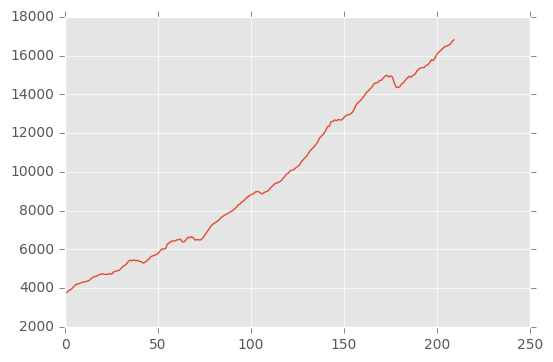

In [27]:
test_stationarity(df_var_t['gdp'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.754592
p-value                          0.403227
#Lags Used                       7.000000
Number of Observations Used    202.000000
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
Critical Value (1%)             -3.463144
dtype: float64


Results of KPSS Test:
Test Statistic            0.805212
p-value                   0.010000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


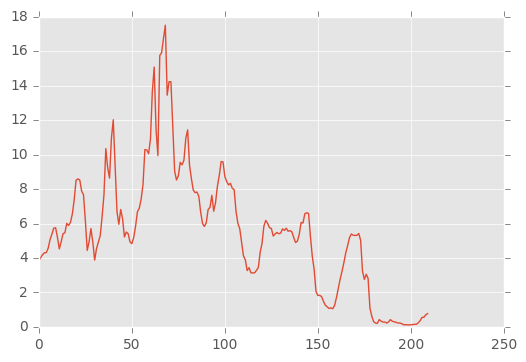

In [28]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.628578
p-value                          0.468235
#Lags Used                      12.000000
Number of Observations Used    197.000000
Critical Value (5%)             -2.876326
Critical Value (10%)            -2.574652
Critical Value (1%)             -3.463987
dtype: float64


Results of KPSS Test:
Test Statistic            0.627924
p-value                   0.020098
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


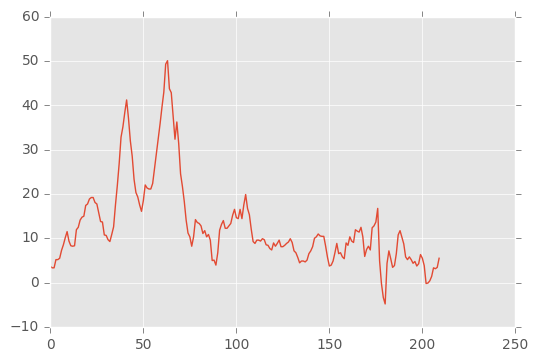

In [29]:
test_stationarity(df_var_t['infr'])

Разности

Results of Dickey-Fuller Test:
Test Statistic                -6.729151e+00
p-value                        3.330094e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.070000e+02
Critical Value (5%)           -2.875606e+00
Critical Value (10%)          -2.574267e+00
Critical Value (1%)           -3.462342e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.305495
p-value                   0.100000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


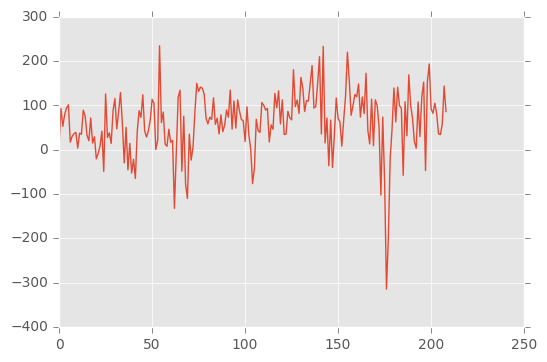

In [30]:
test_stationarity(diff_series(df_var_t['gdp']))

Results of Dickey-Fuller Test:
Test Statistic                -5.919963e+00
p-value                        2.520096e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.020000e+02
Critical Value (5%)           -2.875957e+00
Critical Value (10%)          -2.574455e+00
Critical Value (1%)           -3.463144e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.120741
p-value                   0.100000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


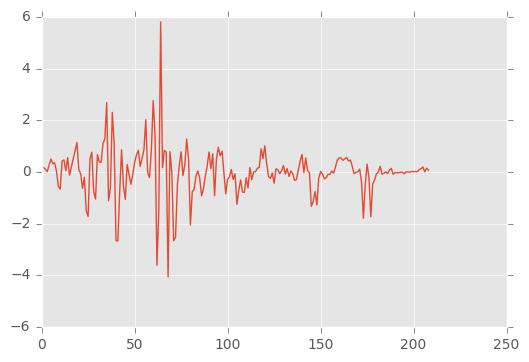

In [31]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                  -5.493664
p-value                          0.000002
#Lags Used                      15.000000
Number of Observations Used    193.000000
Critical Value (5%)             -2.876635
Critical Value (10%)            -2.574816
Critical Value (1%)             -3.464694
dtype: float64


Results of KPSS Test:
Test Statistic            0.110707
p-value                   0.100000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


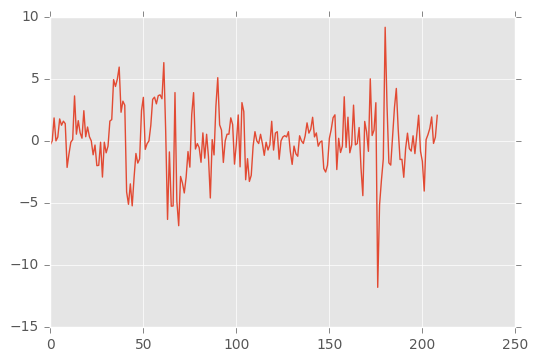

In [32]:
test_stationarity(diff_series(df_var_t['infr']))

In [33]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

#### 6 steps

In [34]:
STEPS = 6
LAG = 4

In [35]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [36]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [37]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='q')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['gdp'], test['gdp']))

{'mae': 0.10723937795122453, 'rmse': 0.12620357161170725, 'mse': 0.01592734148755132}
{'mae': 0.66237363291015627, 'rmse': 0.85244939812447929, 'mse': 0.72666997636278696}
{'mae': 41.911746716544215, 'rmse': 47.617254347286817, 'mse': 2267.4029115742051}


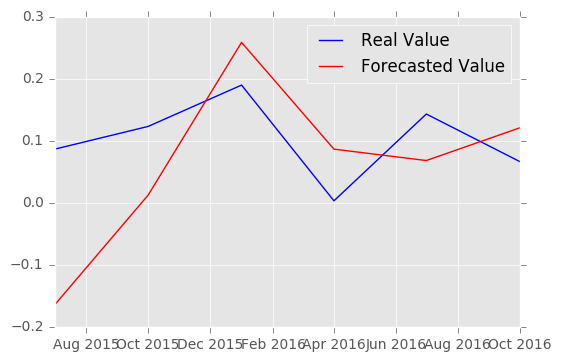

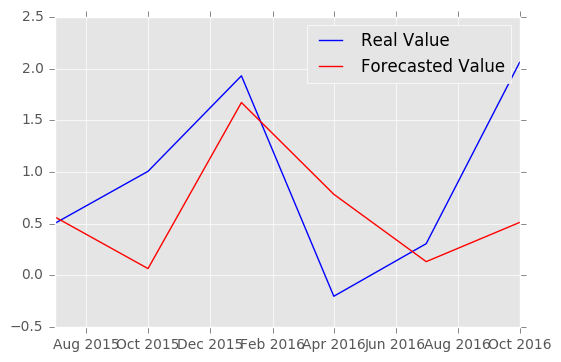

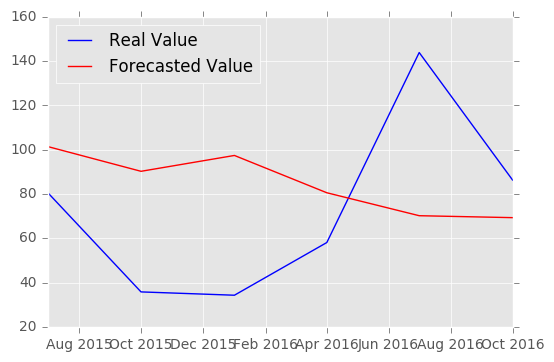

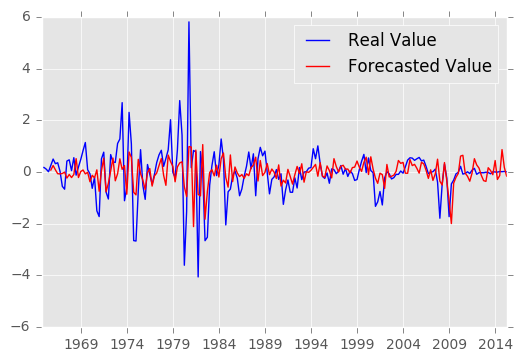

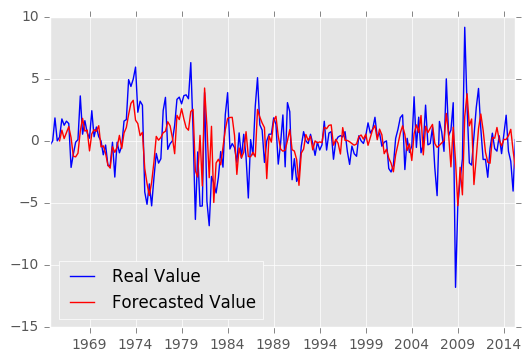

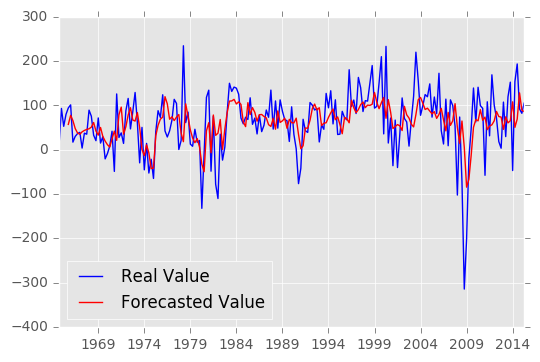

In [38]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['gdp'], test['gdp'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['gdp'], train['gdp'])

{'mae': 0.27170235701304979, 'rmse': 0.27618764417562219, 'mse': 0.076279614795280101}
{'mae': 0.73619560222898162, 'rmse': 0.97348255275684159, 'mse': 0.94766828052197694}
{'mae': 92.069656784963328, 'rmse': 102.95805996455893, 'mse': 10600.362111665712}


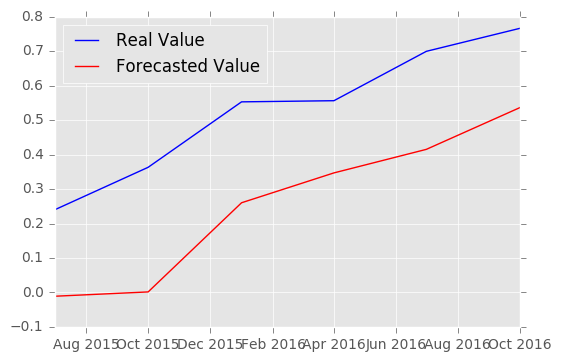

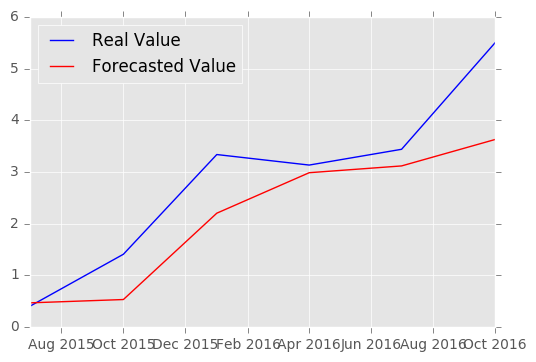

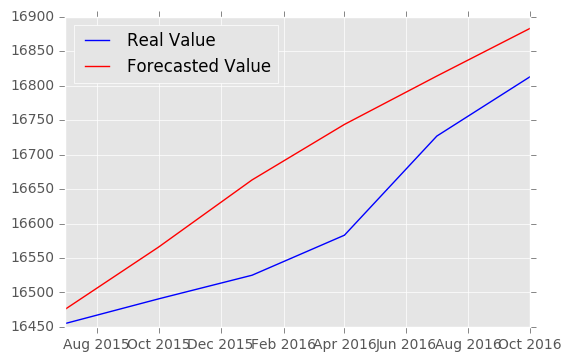

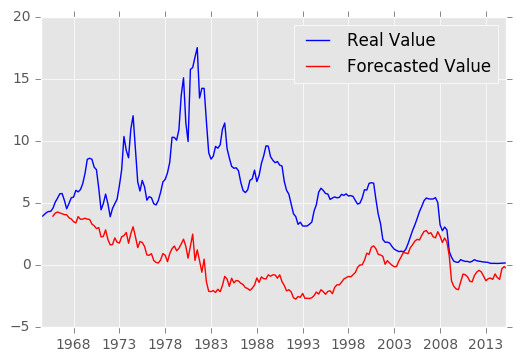

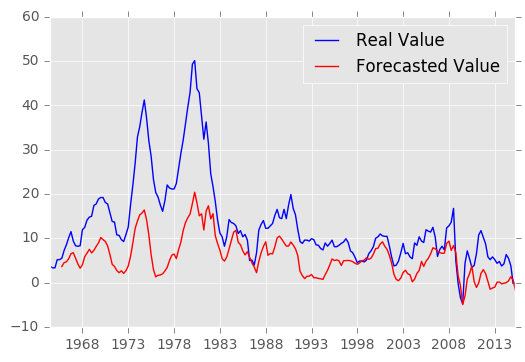

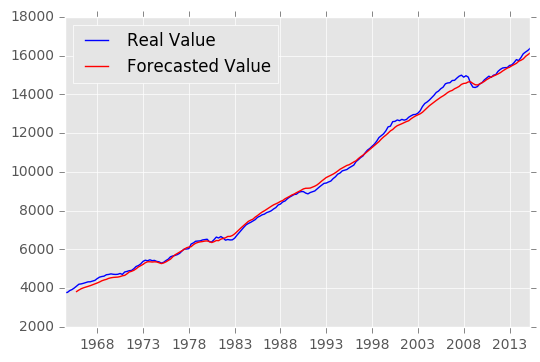

In [39]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['gdp'], test_real['gdp']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['gdp'], test_real['gdp'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['gdp'], train_real['gdp'])

## ANN

In [40]:
df_nn = nn_transform(train, n=LAG)

In [41]:
df_nn_s, m, s = scaler(df_nn)

In [42]:
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [43]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='q'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [44]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [45]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.0205
Epoch 2/600
0s - loss: 0.9946
Epoch 3/600
0s - loss: 0.9848
Epoch 4/600
0s - loss: 0.9708
Epoch 5/600
0s - loss: 0.9610
Epoch 6/600
0s - loss: 0.9495
Epoch 7/600
0s - loss: 0.9402
Epoch 8/600
0s - loss: 0.9299
Epoch 9/600
0s - loss: 0.9210
Epoch 10/600
0s - loss: 0.9080
Epoch 11/600
0s - loss: 0.8980
Epoch 12/600
0s - loss: 0.8885
Epoch 13/600
0s - loss: 0.8790
Epoch 14/600
0s - loss: 0.8686
Epoch 15/600
0s - loss: 0.8624
Epoch 16/600
0s - loss: 0.8518
Epoch 17/600
0s - loss: 0.8424
Epoch 18/600
0s - loss: 0.8355
Epoch 19/600
0s - loss: 0.8270
Epoch 20/600
0s - loss: 0.8189
Epoch 21/600
0s - loss: 0.8129
Epoch 22/600
0s - loss: 0.8042
Epoch 23/600
0s - loss: 0.7973
Epoch 24/600
0s - loss: 0.7901
Epoch 25/600
0s - loss: 0.7843
Epoch 26/600
0s - loss: 0.7815
Epoch 27/600
0s - loss: 0.7711
Epoch 28/600
0s - loss: 0.7672
Epoch 29/600
0s - loss: 0.7620
Epoch 30/600
0s - loss: 0.7561
Epoch 31/600
0s - loss: 0.7518
Epoch 32/600
0s - loss: 0.7459
Epoch 33/600
0s -

In [46]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

{'mae': 0.80639383775393358, 'rmse': 1.1370171263326307, 'mse': 1.2928079455737138}
{'mae': 2.3844052429108507, 'rmse': 2.4783661094351714, 'mse': 6.1422985723968289}
{'mae': 31.568383252840977, 'rmse': 43.011535572077541, 'mse': 1849.9921922680917}


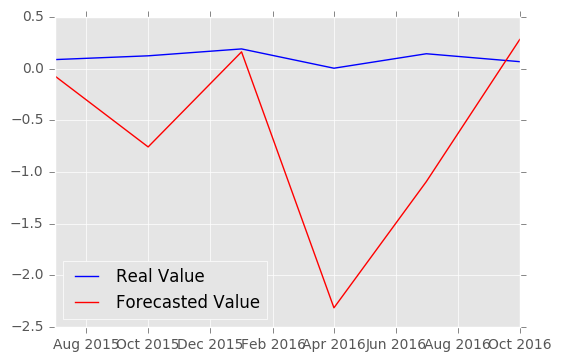

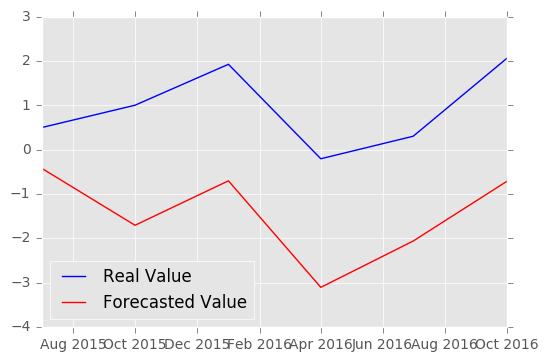

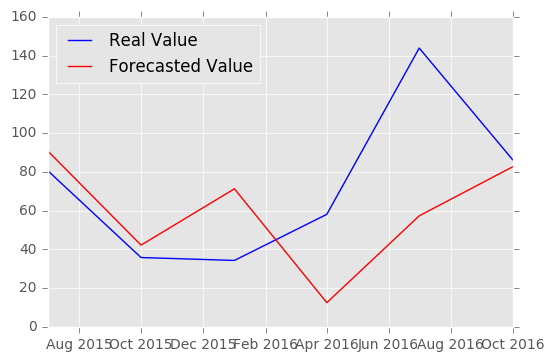

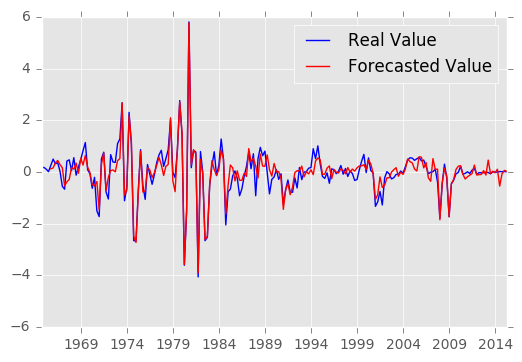

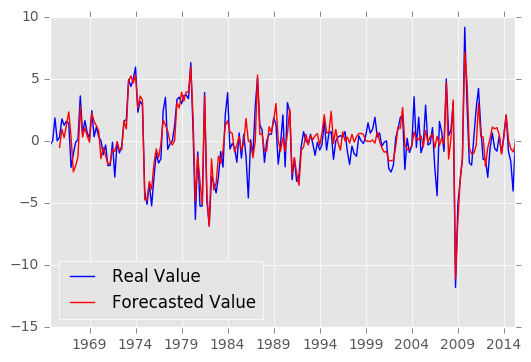

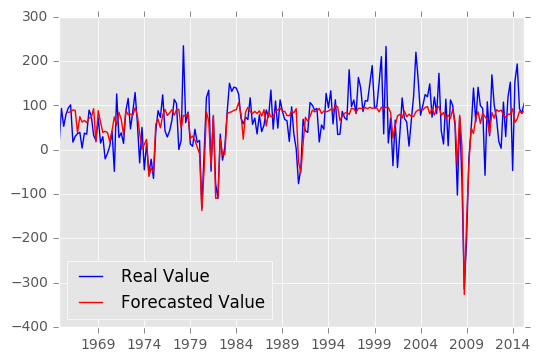

In [47]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 2.4473038599606589, 'rmse': 3.0147720210859736, 'mse': 9.0888503391228053}
{'mae': 7.6345245644291966, 'rmse': 8.8956175088189369, 'mse': 79.13201086320602}
{'mae': 41.532963552185414, 'rmse': 52.076440025254286, 'mse': 2711.9556057039067}


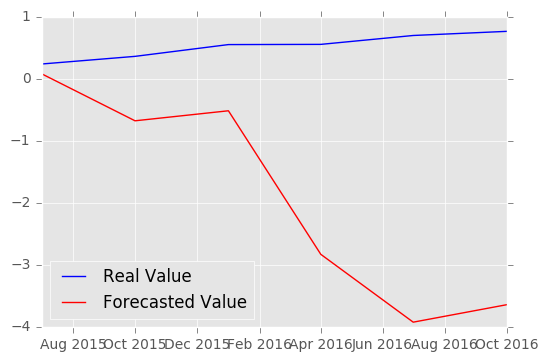

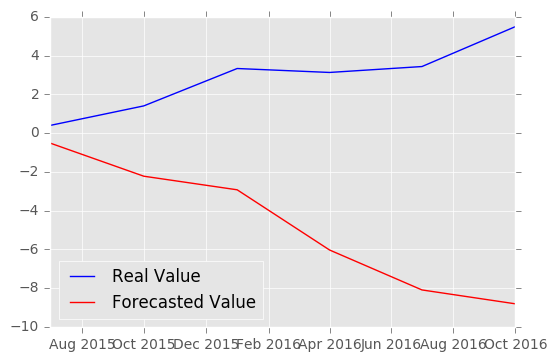

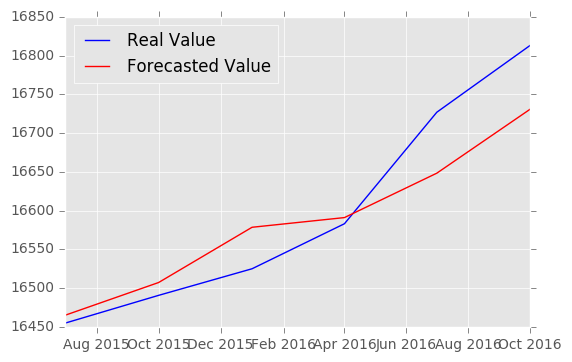

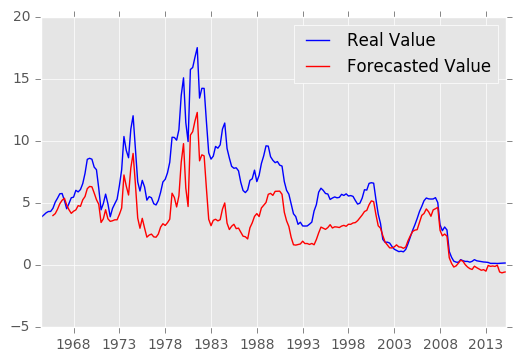

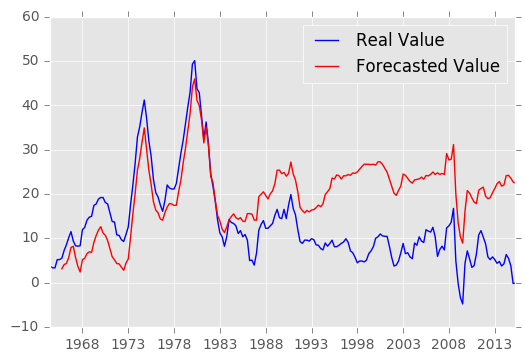

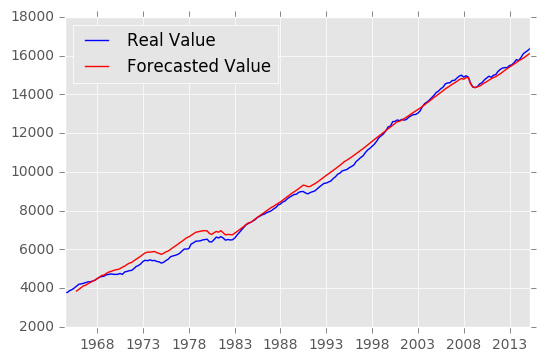

In [48]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

Второй запуск

In [49]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.0363
Epoch 2/600
0s - loss: 0.9811
Epoch 3/600
0s - loss: 0.9728
Epoch 4/600
0s - loss: 0.9625
Epoch 5/600
0s - loss: 0.9519
Epoch 6/600
0s - loss: 0.9438
Epoch 7/600
0s - loss: 0.9349
Epoch 8/600
0s - loss: 0.9241
Epoch 9/600
0s - loss: 0.9184
Epoch 10/600
0s - loss: 0.9081
Epoch 11/600
0s - loss: 0.8998
Epoch 12/600
0s - loss: 0.8879
Epoch 13/600
0s - loss: 0.8799
Epoch 14/600
0s - loss: 0.8690
Epoch 15/600
0s - loss: 0.8631
Epoch 16/600
0s - loss: 0.8540
Epoch 17/600
0s - loss: 0.8457
Epoch 18/600
0s - loss: 0.8363
Epoch 19/600
0s - loss: 0.8289
Epoch 20/600
0s - loss: 0.8200
Epoch 21/600
0s - loss: 0.8127
Epoch 22/600
0s - loss: 0.8022
Epoch 23/600
0s - loss: 0.7990
Epoch 24/600
0s - loss: 0.7922
Epoch 25/600
0s - loss: 0.7844
Epoch 26/600
0s - loss: 0.7759
Epoch 27/600
0s - loss: 0.7702
Epoch 28/600
0s - loss: 0.7676
Epoch 29/600
0s - loss: 0.7599
Epoch 30/600
0s - loss: 0.7563
Epoch 31/600
0s - loss: 0.7490
Epoch 32/600
0s - loss: 0.7457
Epoch 33/600
0s -

{'mae': 0.44025449419592233, 'rmse': 0.51116585637341894, 'mse': 0.26129053272197073}
{'mae': 2.0883310015630707, 'rmse': 2.7634244756669868, 'mse': 7.6365148327153607}
{'mae': 52.235966664553295, 'rmse': 62.966627576697853, 'mse': 3964.7961883825669}


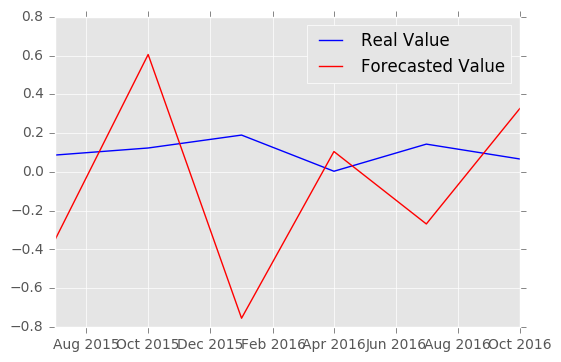

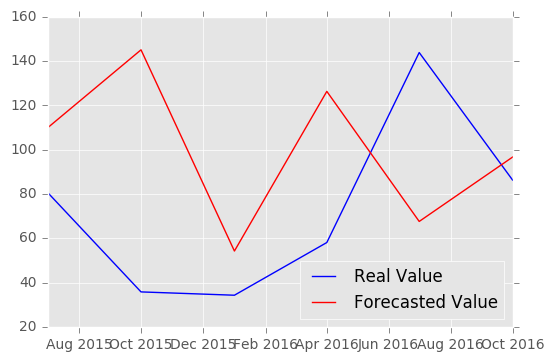

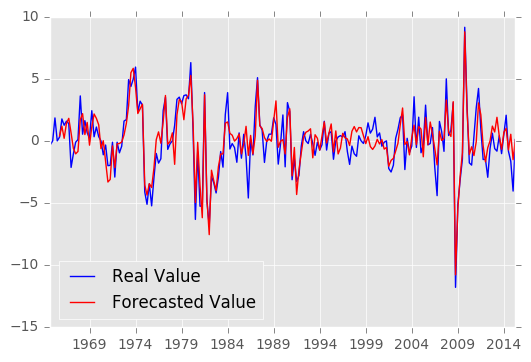

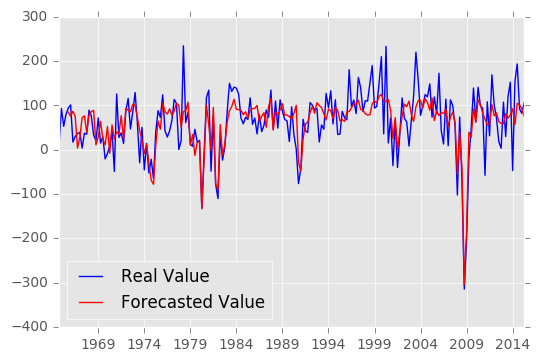

In [50]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 0.72554131549373058, 'rmse': 0.81991322182882043, 'mse': 0.67225769132971658}
{'mae': 5.3490762124047899, 'rmse': 6.1412676308627567, 'mse': 37.715168113882662}
{'mae': 144.04496489201605, 'rmse': 155.5012206093071, 'mse': 24180.629610984393}


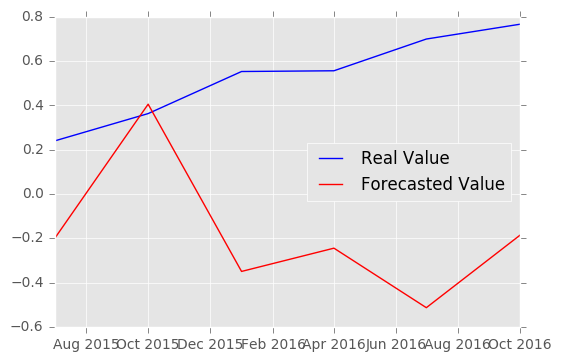

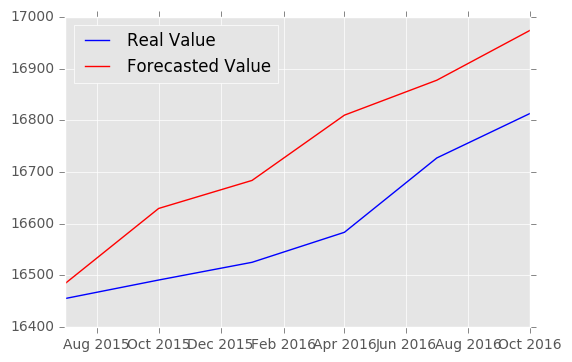

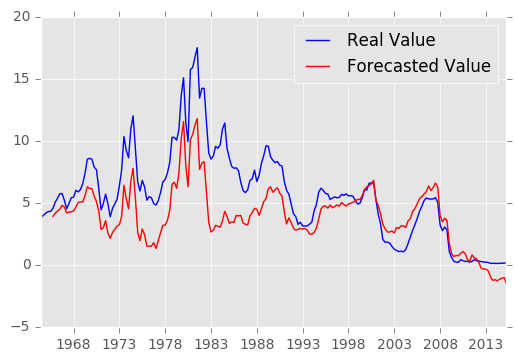

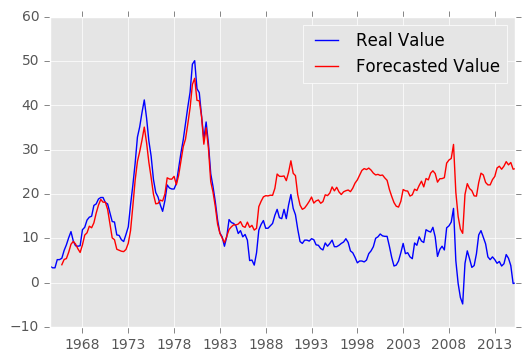

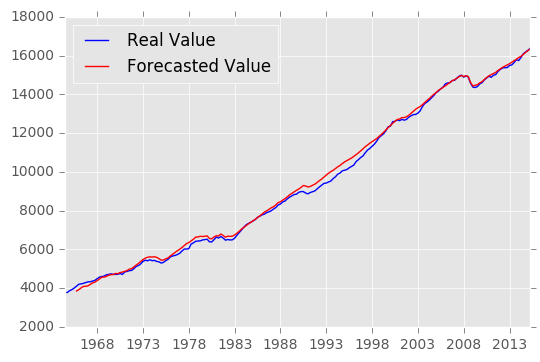

In [51]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

С DropOut

In [52]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.0593
Epoch 2/600
0s - loss: 1.0276
Epoch 3/600
0s - loss: 0.9966
Epoch 4/600
0s - loss: 1.0182
Epoch 5/600
0s - loss: 0.9900
Epoch 6/600
0s - loss: 1.0078
Epoch 7/600
0s - loss: 0.9937
Epoch 8/600
0s - loss: 0.9726
Epoch 9/600
0s - loss: 0.9653
Epoch 10/600
0s - loss: 0.9687
Epoch 11/600
0s - loss: 0.9661
Epoch 12/600
0s - loss: 0.9623
Epoch 13/600
0s - loss: 0.9818
Epoch 14/600
0s - loss: 0.9815
Epoch 15/600
0s - loss: 0.9687
Epoch 16/600
0s - loss: 0.9432
Epoch 17/600
0s - loss: 0.9399
Epoch 18/600
0s - loss: 0.9527
Epoch 19/600
0s - loss: 0.9462
Epoch 20/600
0s - loss: 0.9352
Epoch 21/600
0s - loss: 0.9274
Epoch 22/600
0s - loss: 0.9179
Epoch 23/600
0s - loss: 0.9181
Epoch 24/600
0s - loss: 0.9292
Epoch 25/600
0s - loss: 0.9047
Epoch 26/600
0s - loss: 0.9057
Epoch 27/600
0s - loss: 0.9195
Epoch 28/600
0s - loss: 0.8845
Epoch 29/600
0s - loss: 0.8745
Epoch 30/600
0s - loss: 0.8957
Epoch 31/600
0s - loss: 0.8667
Epoch 32/600
0s - loss: 0.8756
Epoch 33/600
0s -

{'mae': 0.15931855704408046, 'rmse': 0.21314111631223978, 'mse': 0.045429135462827723}
{'mae': 1.4669084618676997, 'rmse': 1.6211513236619206, 'mse': 2.6281316142107971}
{'mae': 25.449094412412922, 'rmse': 33.343778817880739, 'mse': 1111.8075858557524}


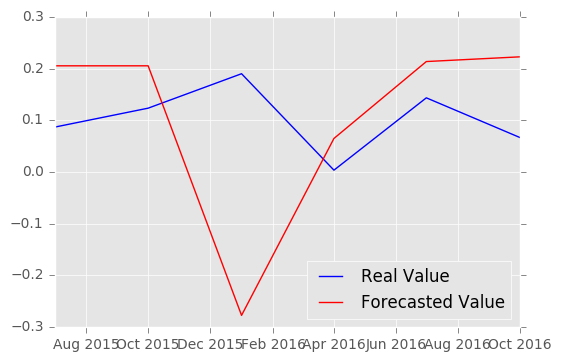

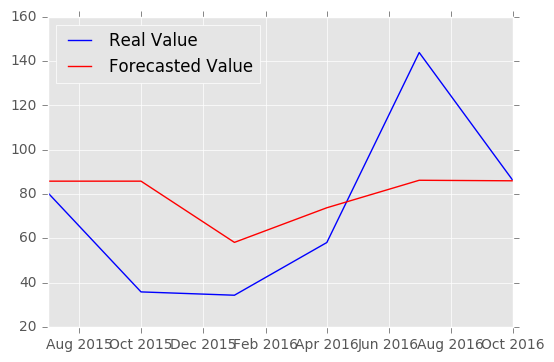

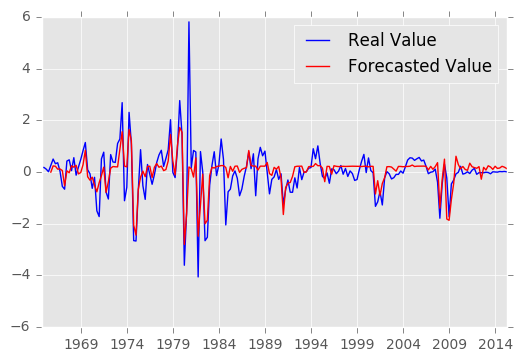

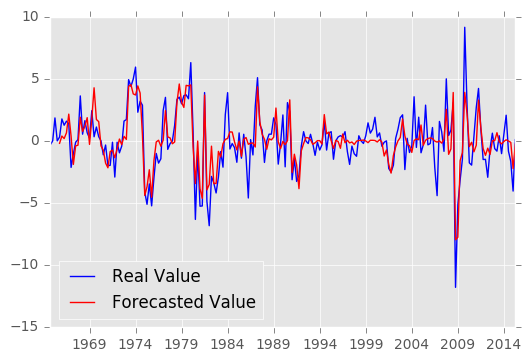

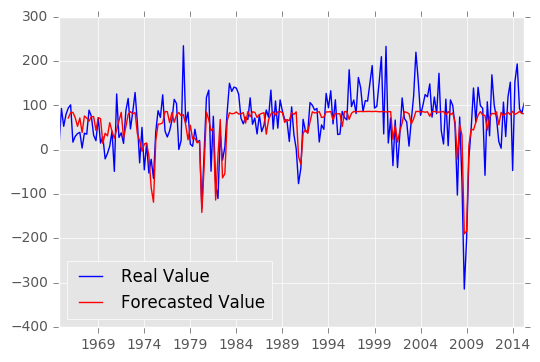

In [53]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 0.15801261791417082, 'rmse': 0.17642700959533791, 'mse': 0.031126489714753458}
{'mae': 5.1749334577554533, 'rmse': 5.8056532323681944, 'mse': 33.705609454507268}
{'mae': 51.268247046251417, 'rmse': 59.14080184386733, 'mse': 3497.6344427355812}


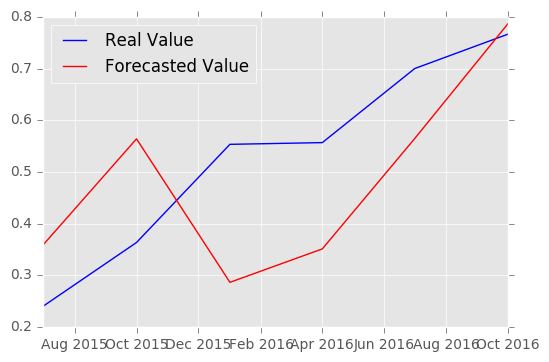

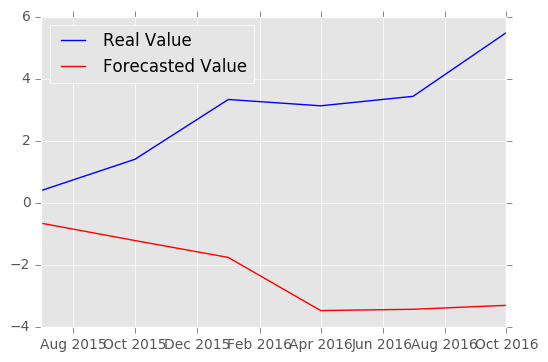

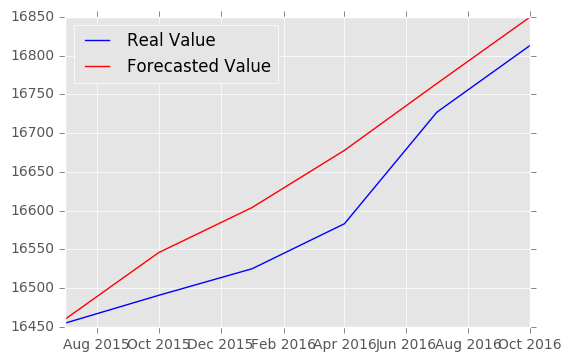

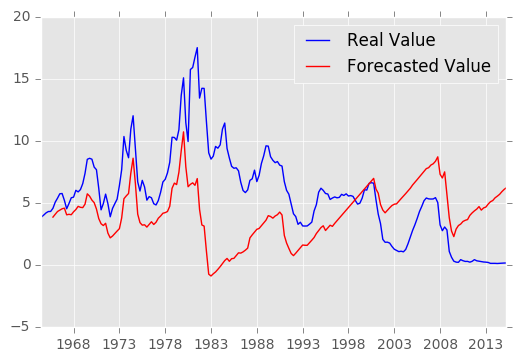

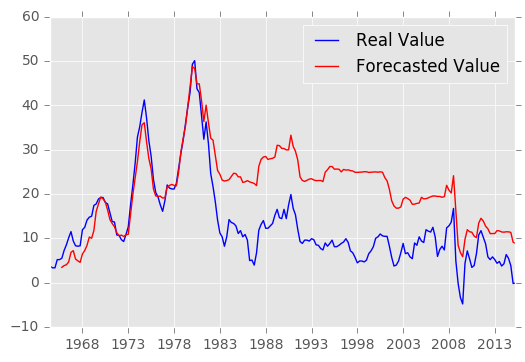

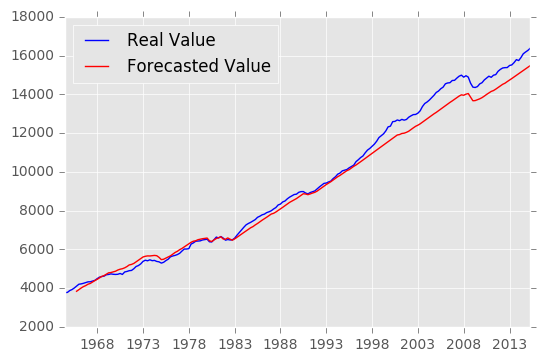

In [54]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

На оригинальных данных, а не разницах

In [55]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [56]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.0968
Epoch 2/600
0s - loss: 0.6517
Epoch 3/600
0s - loss: 0.4918
Epoch 4/600
0s - loss: 0.4094
Epoch 5/600
0s - loss: 0.3608
Epoch 6/600
0s - loss: 0.3276
Epoch 7/600
0s - loss: 0.2990
Epoch 8/600
0s - loss: 0.2753
Epoch 9/600
0s - loss: 0.2556
Epoch 10/600
0s - loss: 0.2375
Epoch 11/600
0s - loss: 0.2213
Epoch 12/600
0s - loss: 0.2072
Epoch 13/600
0s - loss: 0.1945
Epoch 14/600
0s - loss: 0.1835
Epoch 15/600
0s - loss: 0.1728
Epoch 16/600
0s - loss: 0.1657
Epoch 17/600
0s - loss: 0.1572
Epoch 18/600
0s - loss: 0.1482
Epoch 19/600
0s - loss: 0.1411
Epoch 20/600
0s - loss: 0.1350
Epoch 21/600
0s - loss: 0.1287
Epoch 22/600
0s - loss: 0.1207
Epoch 23/600
0s - loss: 0.1145
Epoch 24/600
0s - loss: 0.1087
Epoch 25/600
0s - loss: 0.1024
Epoch 26/600
0s - loss: 0.0970
Epoch 27/600
0s - loss: 0.0900
Epoch 28/600
0s - loss: 0.0860
Epoch 29/600
0s - loss: 0.0808
Epoch 30/600
0s - loss: 0.0775
Epoch 31/600
0s - loss: 0.0723
Epoch 32/600
0s - loss: 0.0689
Epoch 33/600
0s -

{'mae': 2.3474656602687847, 'rmse': 2.4980287469597982, 'mse': 6.2401476206375399}
{'mae': 8.8878624273374296, 'rmse': 9.7208050982450924, 'mse': 94.494051758067769}
{'mae': 505.47599615266336, 'rmse': 586.60315233469225, 'mse': 344103.25832899823}


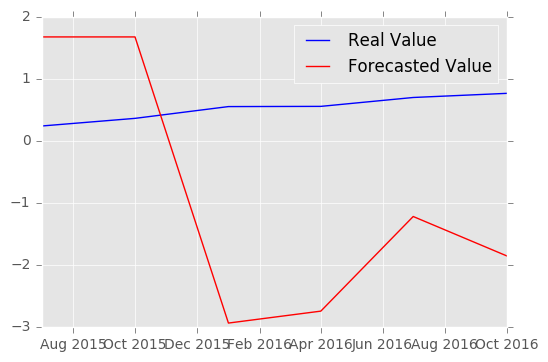

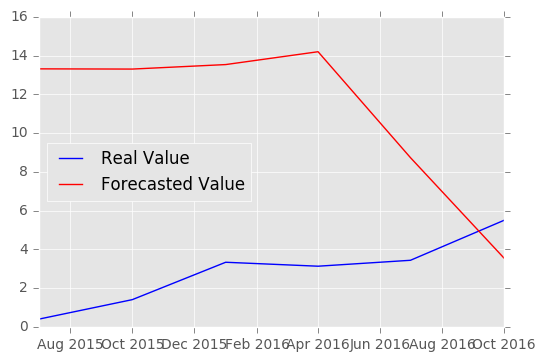

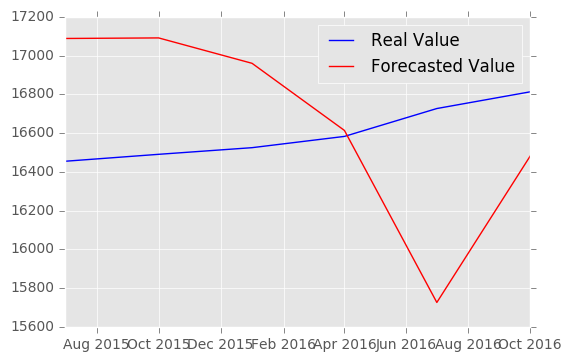

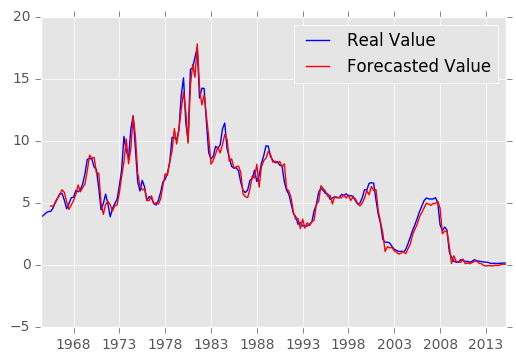

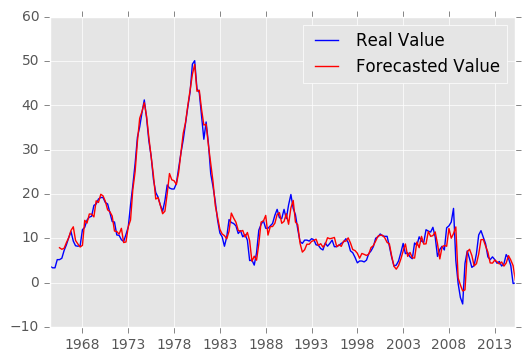

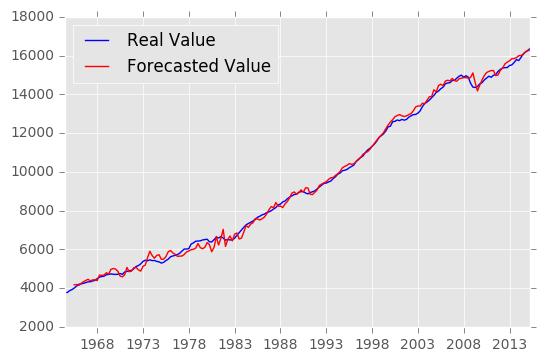

In [57]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

Второй запуск (не на разницах)

In [58]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.0313
Epoch 2/600
0s - loss: 0.8002
Epoch 3/600
0s - loss: 0.6549
Epoch 4/600
0s - loss: 0.5302
Epoch 5/600
0s - loss: 0.4341
Epoch 6/600
0s - loss: 0.3692
Epoch 7/600
0s - loss: 0.3250
Epoch 8/600
0s - loss: 0.2919
Epoch 9/600
0s - loss: 0.2617
Epoch 10/600
0s - loss: 0.2339
Epoch 11/600
0s - loss: 0.2094
Epoch 12/600
0s - loss: 0.1879
Epoch 13/600
0s - loss: 0.1693
Epoch 14/600
0s - loss: 0.1535
Epoch 15/600
0s - loss: 0.1393
Epoch 16/600
0s - loss: 0.1276
Epoch 17/600
0s - loss: 0.1182
Epoch 18/600
0s - loss: 0.1095
Epoch 19/600
0s - loss: 0.1012
Epoch 20/600
0s - loss: 0.0952
Epoch 21/600
0s - loss: 0.0894
Epoch 22/600
0s - loss: 0.0848
Epoch 23/600
0s - loss: 0.0805
Epoch 24/600
0s - loss: 0.0766
Epoch 25/600
0s - loss: 0.0744
Epoch 26/600
0s - loss: 0.0717
Epoch 27/600
0s - loss: 0.0683
Epoch 28/600
0s - loss: 0.0664
Epoch 29/600
0s - loss: 0.0647
Epoch 30/600
0s - loss: 0.0635
Epoch 31/600
0s - loss: 0.0620
Epoch 32/600
0s - loss: 0.0609
Epoch 33/600
0s -

{'mae': 3.0197552212803704, 'rmse': 3.3350152034475999, 'mse': 11.122326407226637}
{'mae': 8.9295988951755003, 'rmse': 10.434859031849687, 'mse': 108.886283014575}
{'mae': 1616.6258301444668, 'rmse': 1821.0013630211329, 'mse': 3316045.9641248235}


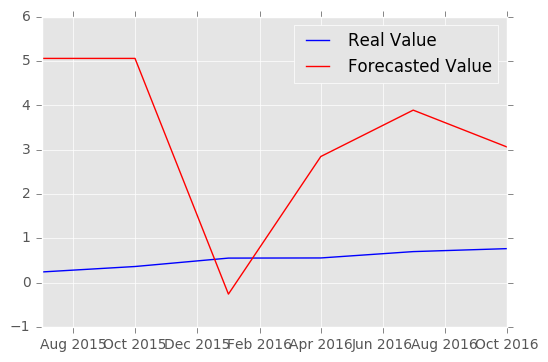

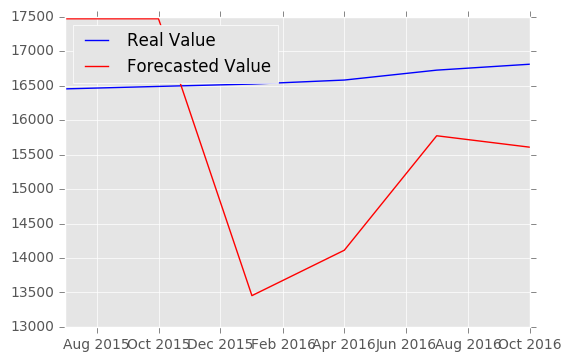

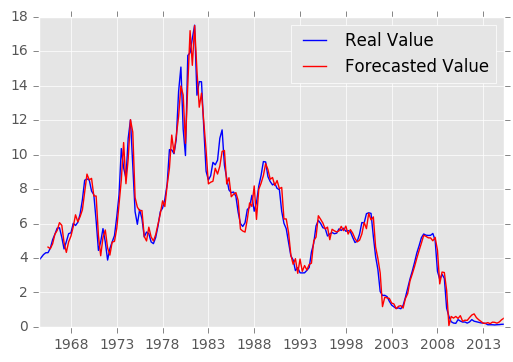

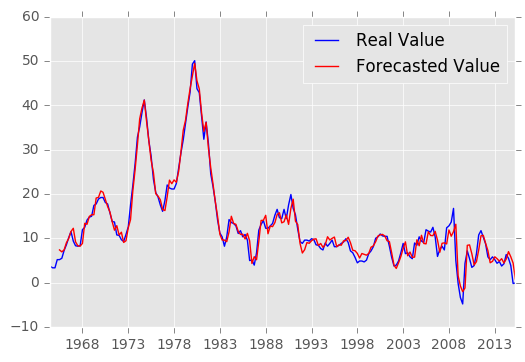

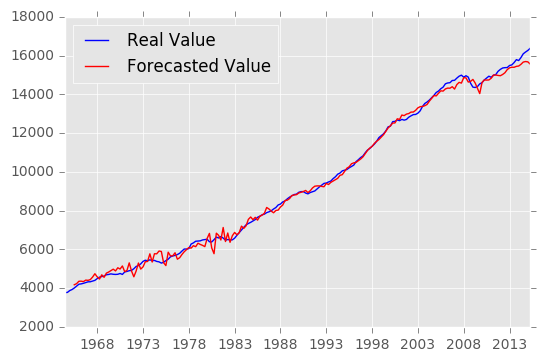

In [59]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

С DropOut

In [60]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 0.9705
Epoch 2/600
0s - loss: 0.7829
Epoch 3/600
0s - loss: 0.6454
Epoch 4/600
0s - loss: 0.5289
Epoch 5/600
0s - loss: 0.4460
Epoch 6/600
0s - loss: 0.3872
Epoch 7/600
0s - loss: 0.3450
Epoch 8/600
0s - loss: 0.3114
Epoch 9/600
0s - loss: 0.2803
Epoch 10/600
0s - loss: 0.2525
Epoch 11/600
0s - loss: 0.2270
Epoch 12/600
0s - loss: 0.2036
Epoch 13/600
0s - loss: 0.1838
Epoch 14/600
0s - loss: 0.1670
Epoch 15/600
0s - loss: 0.1499
Epoch 16/600
0s - loss: 0.1360
Epoch 17/600
0s - loss: 0.1236
Epoch 18/600
0s - loss: 0.1122
Epoch 19/600
0s - loss: 0.1016
Epoch 20/600
0s - loss: 0.0948
Epoch 21/600
0s - loss: 0.0870
Epoch 22/600
0s - loss: 0.0810
Epoch 23/600
0s - loss: 0.0765
Epoch 24/600
0s - loss: 0.0729
Epoch 25/600
0s - loss: 0.0697
Epoch 26/600
0s - loss: 0.0679
Epoch 27/600
0s - loss: 0.0661
Epoch 28/600
0s - loss: 0.0640
Epoch 29/600
0s - loss: 0.0621
Epoch 30/600
0s - loss: 0.0617
Epoch 31/600
0s - loss: 0.0604
Epoch 32/600
0s - loss: 0.0585
Epoch 33/600
0s -

{'mae': 3.1401268160763647, 'rmse': 3.8524902062498936, 'mse': 14.841680789251347}
{'mae': 10.612569343132703, 'rmse': 11.600618241079781, 'mse': 134.57434357527293}
{'mae': 1253.7707213049191, 'rmse': 1553.7751425757947, 'mse': 2414217.1936864313}


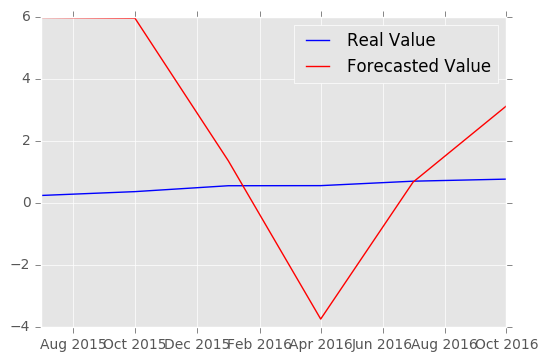

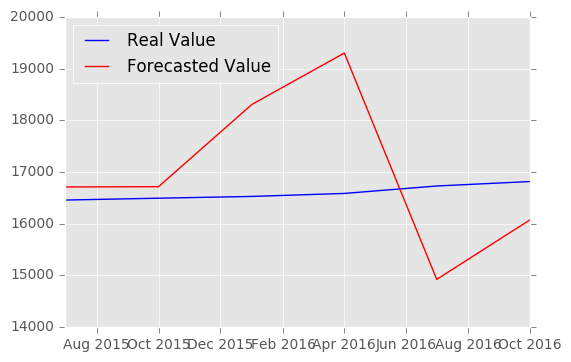

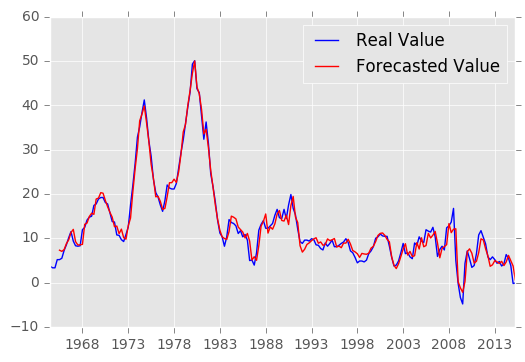

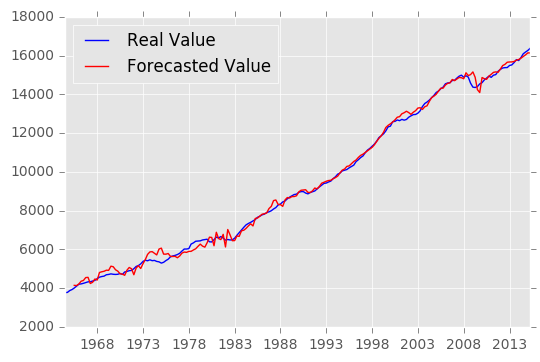

In [61]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

## Hybrid

In [62]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [63]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [64]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.2811
Epoch 2/200
0s - loss: 1.0154
Epoch 3/200
0s - loss: 1.0084
Epoch 4/200
0s - loss: 1.0062
Epoch 5/200
0s - loss: 1.0030
Epoch 6/200
0s - loss: 1.0011
Epoch 7/200
0s - loss: 1.0010
Epoch 8/200
0s - loss: 1.0017
Epoch 9/200
0s - loss: 0.9991
Epoch 10/200
0s - loss: 0.9947
Epoch 11/200
0s - loss: 0.9960
Epoch 12/200
0s - loss: 0.9936
Epoch 13/200
0s - loss: 0.9936
Epoch 14/200
0s - loss: 0.9946
Epoch 15/200
0s - loss: 0.9897
Epoch 16/200
0s - loss: 0.9906
Epoch 17/200
0s - loss: 0.9894
Epoch 18/200
0s - loss: 0.9871
Epoch 19/200
0s - loss: 0.9872
Epoch 20/200
0s - loss: 0.9858
Epoch 21/200
0s - loss: 0.9848
Epoch 22/200
0s - loss: 0.9850
Epoch 23/200
0s - loss: 0.9817
Epoch 24/200
0s - loss: 0.9815
Epoch 25/200
0s - loss: 0.9800
Epoch 26/200
0s - loss: 0.9779
Epoch 27/200
0s - loss: 0.9789
Epoch 28/200
0s - loss: 0.9771
Epoch 29/200
0s - loss: 0.9762
Epoch 30/200
0s - loss: 0.9736
Epoch 31/200
0s - loss: 0.9716
Epoch 32/200
0s - loss: 0.9687
Epoch 33/200
0s -

{'mae': 0.69980311542483442, 'rmse': 0.99140396575800471, 'mse': 0.98288182332069907}
{'mae': 1.2274396660109514, 'rmse': 1.430567770317275, 'mse': 2.0465241454705398}
{'mae': 49.421495893652462, 'rmse': 63.244753373980224, 'mse': 3999.8988293355828}


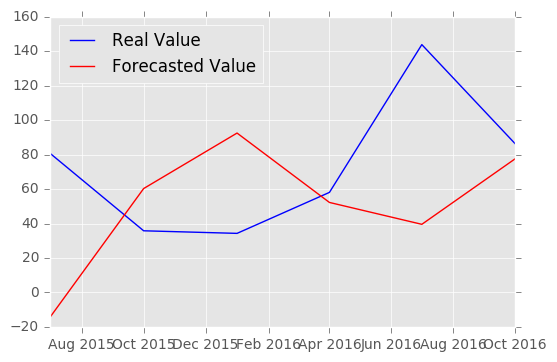

In [65]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 3.1652573267043231, 'rmse': 3.2235184552516811, 'mse': 10.391071231348183}
{'mae': 4.8679592663084854, 'rmse': 5.1670530460305306, 'mse': 26.698437180493382}
{'mae': 74.794098064061174, 'rmse': 88.089545924552993, 'mse': 7759.7681011939303}


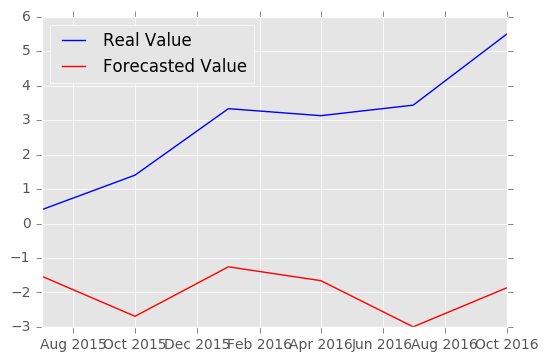

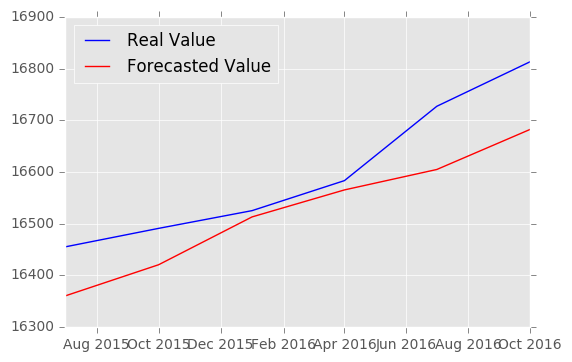

In [66]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

Второй запуск

In [67]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.0873
Epoch 2/200
0s - loss: 1.0067
Epoch 3/200
0s - loss: 1.0042
Epoch 4/200
0s - loss: 1.0025
Epoch 5/200
0s - loss: 1.0016
Epoch 6/200
0s - loss: 1.0037
Epoch 7/200
0s - loss: 0.9991
Epoch 8/200
0s - loss: 0.9963
Epoch 9/200
0s - loss: 0.9934
Epoch 10/200
0s - loss: 0.9946
Epoch 11/200
0s - loss: 0.9926
Epoch 12/200
0s - loss: 0.9940
Epoch 13/200
0s - loss: 0.9909
Epoch 14/200
0s - loss: 0.9888
Epoch 15/200
0s - loss: 0.9879
Epoch 16/200
0s - loss: 0.9864
Epoch 17/200
0s - loss: 0.9834
Epoch 18/200
0s - loss: 0.9822
Epoch 19/200
0s - loss: 0.9805
Epoch 20/200
0s - loss: 0.9791
Epoch 21/200
0s - loss: 0.9791
Epoch 22/200
0s - loss: 0.9780
Epoch 23/200
0s - loss: 0.9764
Epoch 24/200
0s - loss: 0.9723
Epoch 25/200
0s - loss: 0.9721
Epoch 26/200
0s - loss: 0.9723
Epoch 27/200
0s - loss: 0.9699
Epoch 28/200
0s - loss: 0.9683
Epoch 29/200
0s - loss: 0.9693
Epoch 30/200
0s - loss: 0.9668
Epoch 31/200
0s - loss: 0.9658
Epoch 32/200
0s - loss: 0.9623
Epoch 33/200
0s -

{'mae': 0.58776273564819226, 'rmse': 0.73612769522122301, 'mse': 0.54188398367170987}
{'mae': 2.0520002739303558, 'rmse': 2.5017248559147074, 'mse': 6.2586272547014632}
{'mae': 51.397944528231108, 'rmse': 62.394646085418387, 'mse': 3893.0918601246158}


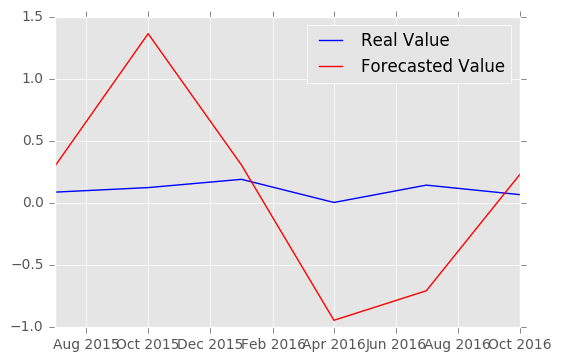

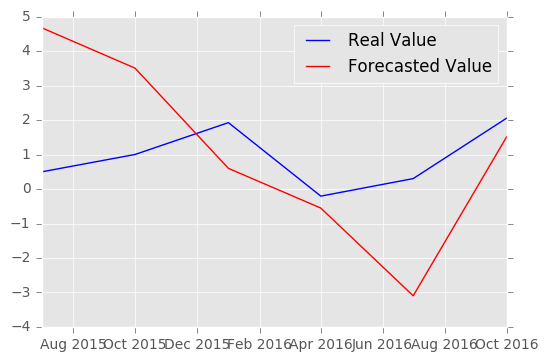

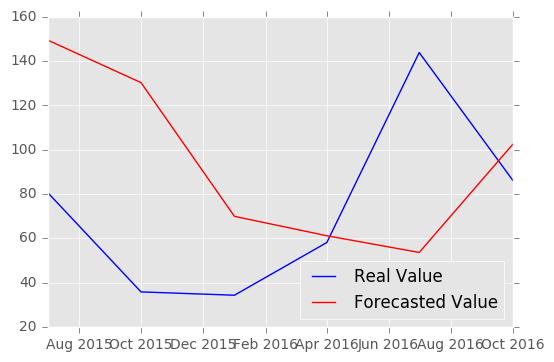

In [68]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 0.69138565099572746, 'rmse': 0.91499782882272762, 'mse': 0.83722102675030552}
{'mae': 3.9906837295750583, 'rmse': 4.472014705709431, 'mse': 19.998915528081408}
{'mae': 145.46257726875228, 'rmse': 153.11169414525131, 'mse': 23443.190884028987}


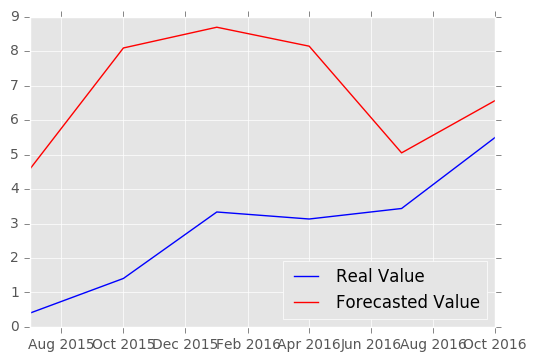

In [69]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

С DropOut

In [70]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.2270
Epoch 2/200
0s - loss: 1.0218
Epoch 3/200
0s - loss: 1.0143
Epoch 4/200
0s - loss: 1.0091
Epoch 5/200
0s - loss: 1.0156
Epoch 6/200
0s - loss: 1.0158
Epoch 7/200
0s - loss: 1.0023
Epoch 8/200
0s - loss: 1.0073
Epoch 9/200
0s - loss: 1.0019
Epoch 10/200
0s - loss: 0.9992
Epoch 11/200
0s - loss: 1.0036
Epoch 12/200
0s - loss: 0.9949
Epoch 13/200
0s - loss: 0.9990
Epoch 14/200
0s - loss: 0.9954
Epoch 15/200
0s - loss: 1.0029
Epoch 16/200
0s - loss: 0.9935
Epoch 17/200
0s - loss: 0.9844
Epoch 18/200
0s - loss: 0.9988
Epoch 19/200
0s - loss: 0.9925
Epoch 20/200
0s - loss: 0.9878
Epoch 21/200
0s - loss: 1.0078
Epoch 22/200
0s - loss: 0.9969
Epoch 23/200
0s - loss: 1.0012
Epoch 24/200
0s - loss: 0.9925
Epoch 25/200
0s - loss: 0.9930
Epoch 26/200
0s - loss: 0.9873
Epoch 27/200
0s - loss: 0.9831
Epoch 28/200
0s - loss: 1.0050
Epoch 29/200
0s - loss: 1.0038
Epoch 30/200
0s - loss: 1.0043
Epoch 31/200
0s - loss: 0.9888
Epoch 32/200
0s - loss: 0.9892
Epoch 33/200
0s -

{'mae': 0.12264690734863049, 'rmse': 0.1641405360942057, 'mse': 0.026942115589293242}
{'mae': 0.84329846404567688, 'rmse': 0.96865475888702035, 'mse': 0.93829204191447158}
{'mae': 41.466455931155913, 'rmse': 46.11463096963314, 'mse': 2126.5591894654476}


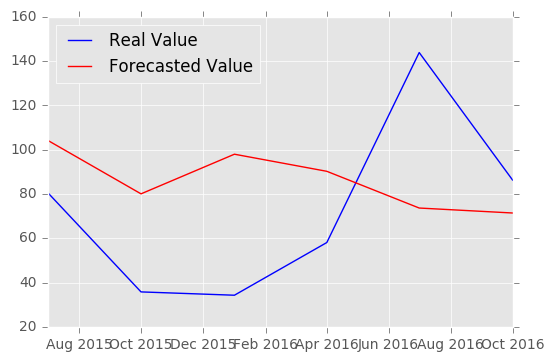

In [71]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 0.4937457358356252, 'rmse': 0.50302530429045422, 'mse': 0.25303445675650404}
{'mae': 0.67912393563620865, 'rmse': 0.99206571494916129, 'mse': 0.98419438277759053}
{'mae': 93.136253476744969, 'rmse': 103.4327346904097, 'mse': 10698.330605536683}


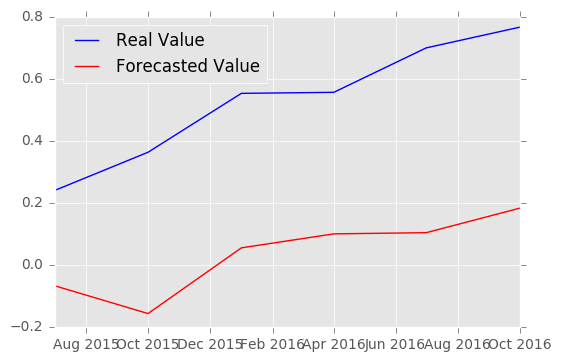

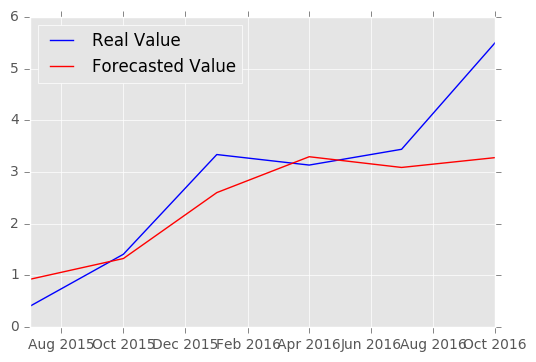

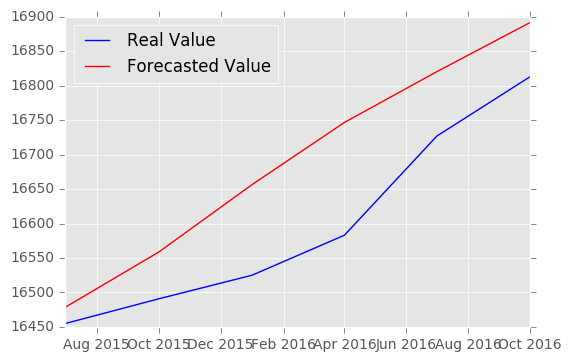

In [72]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

### Hybrid Full

In [73]:
def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [74]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 0.9709
Epoch 2/500
0s - loss: 0.8231
Epoch 3/500
0s - loss: 0.6985
Epoch 4/500
0s - loss: 0.5883
Epoch 5/500
0s - loss: 0.4990
Epoch 6/500
0s - loss: 0.4304
Epoch 7/500
0s - loss: 0.3788
Epoch 8/500
0s - loss: 0.3366
Epoch 9/500
0s - loss: 0.3037
Epoch 10/500
0s - loss: 0.2746
Epoch 11/500
0s - loss: 0.2530
Epoch 12/500
0s - loss: 0.2317
Epoch 13/500
0s - loss: 0.2153
Epoch 14/500
0s - loss: 0.2014
Epoch 15/500
0s - loss: 0.1874
Epoch 16/500
0s - loss: 0.1757
Epoch 17/500
0s - loss: 0.1649
Epoch 18/500
0s - loss: 0.1551
Epoch 19/500
0s - loss: 0.1469
Epoch 20/500
0s - loss: 0.1393
Epoch 21/500
0s - loss: 0.1333
Epoch 22/500
0s - loss: 0.1276
Epoch 23/500
0s - loss: 0.1231
Epoch 24/500
0s - loss: 0.1187
Epoch 25/500
0s - loss: 0.1152
Epoch 26/500
0s - loss: 0.1117
Epoch 27/500
0s - loss: 0.1102
Epoch 28/500
0s - loss: 0.1067
Epoch 29/500
0s - loss: 0.1047
Epoch 30/500
0s - loss: 0.1029
Epoch 31/500
0s - loss: 0.1004
Epoch 32/500
0s - loss: 0.0991
Epoch 33/500
0s -

{'mae': 3.0855737791207045, 'rmse': 3.3006180316627902, 'mse': 10.89407939093755}
{'mae': 1.41354725753952, 'rmse': 1.6473931269863868, 'mse': 2.7139041148419856}
{'mae': 190.97519184829375, 'rmse': 223.91876675963502, 'mse': 50139.61410715583}


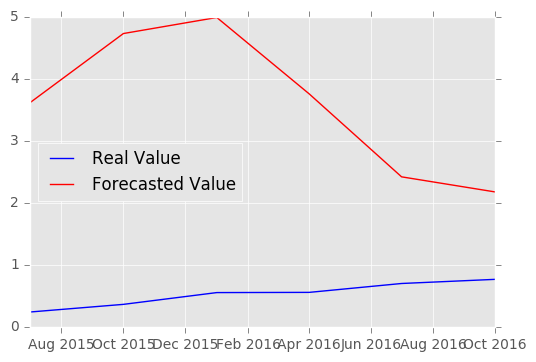

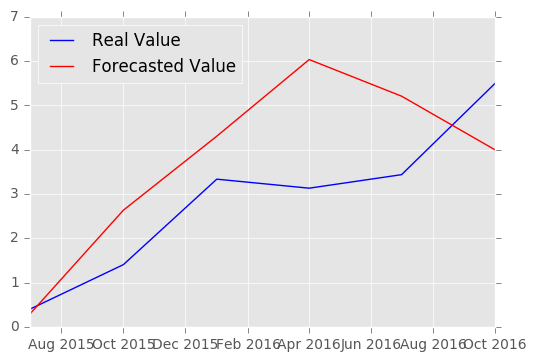

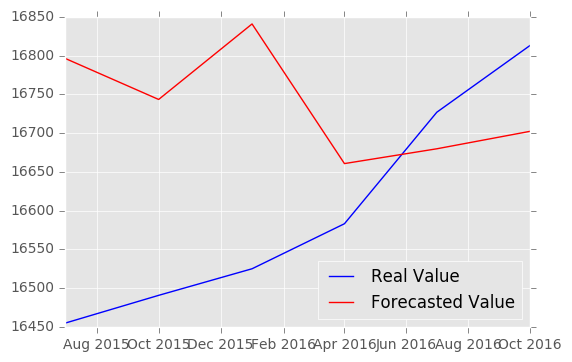

In [75]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

Второй запуск

In [76]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.2688
Epoch 2/500
0s - loss: 0.8741
Epoch 3/500
0s - loss: 0.7324
Epoch 4/500
0s - loss: 0.6234
Epoch 5/500
0s - loss: 0.5266
Epoch 6/500
0s - loss: 0.4473
Epoch 7/500
0s - loss: 0.3888
Epoch 8/500
0s - loss: 0.3470
Epoch 9/500
0s - loss: 0.3170
Epoch 10/500
0s - loss: 0.2948
Epoch 11/500
0s - loss: 0.2795
Epoch 12/500
0s - loss: 0.2664
Epoch 13/500
0s - loss: 0.2574
Epoch 14/500
0s - loss: 0.2470
Epoch 15/500
0s - loss: 0.2367
Epoch 16/500
0s - loss: 0.2264
Epoch 17/500
0s - loss: 0.2165
Epoch 18/500
0s - loss: 0.2060
Epoch 19/500
0s - loss: 0.1962
Epoch 20/500
0s - loss: 0.1858
Epoch 21/500
0s - loss: 0.1763
Epoch 22/500
0s - loss: 0.1675
Epoch 23/500
0s - loss: 0.1589
Epoch 24/500
0s - loss: 0.1512
Epoch 25/500
0s - loss: 0.1438
Epoch 26/500
0s - loss: 0.1378
Epoch 27/500
0s - loss: 0.1326
Epoch 28/500
0s - loss: 0.1278
Epoch 29/500
0s - loss: 0.1229
Epoch 30/500
0s - loss: 0.1220
Epoch 31/500
0s - loss: 0.1178
Epoch 32/500
0s - loss: 0.1149
Epoch 33/500
0s -

{'mae': 7.8349363807074823, 'rmse': 8.2787430304739971, 'mse': 68.537586164621786}
{'mae': 3.9865103128196502, 'rmse': 4.9677994399026009, 'mse': 24.679031275096591}
{'mae': 236.20686043780188, 'rmse': 303.8920653205671, 'mse': 92350.387364799812}


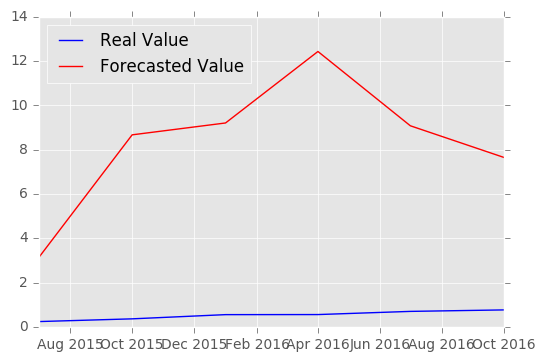

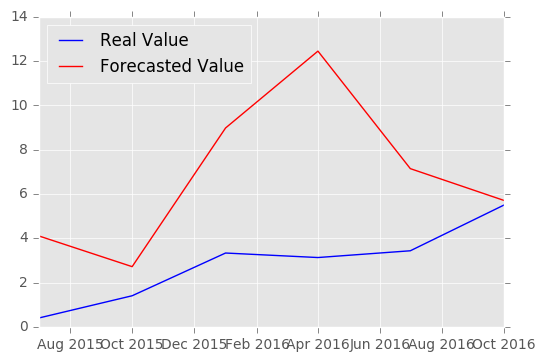

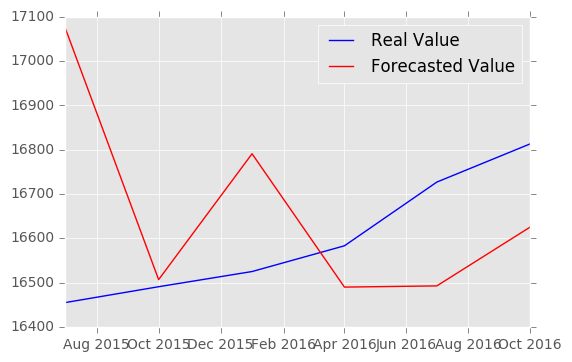

In [77]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

C DropOut

In [78]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.0645
Epoch 2/500
0s - loss: 0.9807
Epoch 3/500
0s - loss: 0.9120
Epoch 4/500
0s - loss: 0.9240
Epoch 5/500
0s - loss: 0.8595
Epoch 6/500
0s - loss: 0.8077
Epoch 7/500
0s - loss: 0.7664
Epoch 8/500
0s - loss: 0.7771
Epoch 9/500
0s - loss: 0.6993
Epoch 10/500
0s - loss: 0.7114
Epoch 11/500
0s - loss: 0.7325
Epoch 12/500
0s - loss: 0.6967
Epoch 13/500
0s - loss: 0.7011
Epoch 14/500
0s - loss: 0.6944
Epoch 15/500
0s - loss: 0.6512
Epoch 16/500
0s - loss: 0.6723
Epoch 17/500
0s - loss: 0.6319
Epoch 18/500
0s - loss: 0.6284
Epoch 19/500
0s - loss: 0.6611
Epoch 20/500
0s - loss: 0.6481
Epoch 21/500
0s - loss: 0.6604
Epoch 22/500
0s - loss: 0.6224
Epoch 23/500
0s - loss: 0.6167
Epoch 24/500
0s - loss: 0.6329
Epoch 25/500
0s - loss: 0.6099
Epoch 26/500
0s - loss: 0.6066
Epoch 27/500
0s - loss: 0.6281
Epoch 28/500
0s - loss: 0.6309
Epoch 29/500
0s - loss: 0.6244
Epoch 30/500
0s - loss: 0.6370
Epoch 31/500
0s - loss: 0.6202
Epoch 32/500
0s - loss: 0.6088
Epoch 33/500
0s -

{'mae': 5.2250489658257928, 'rmse': 5.939982596946181, 'mse': 35.283393252023501}
{'mae': 4.3377870779066514, 'rmse': 4.5684028072330465, 'mse': 20.870304209134783}
{'mae': 157.78612956934799, 'rmse': 190.8023109146875, 'mse': 36405.52185038507}


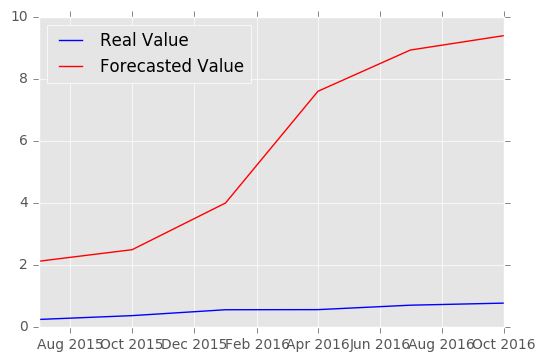

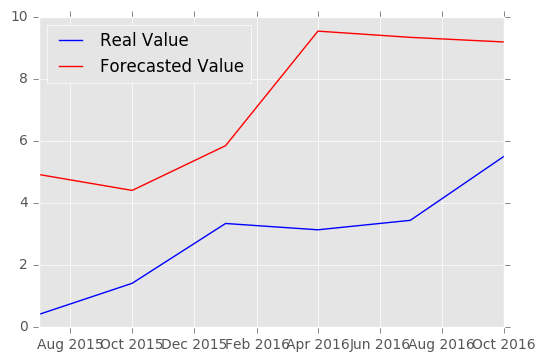

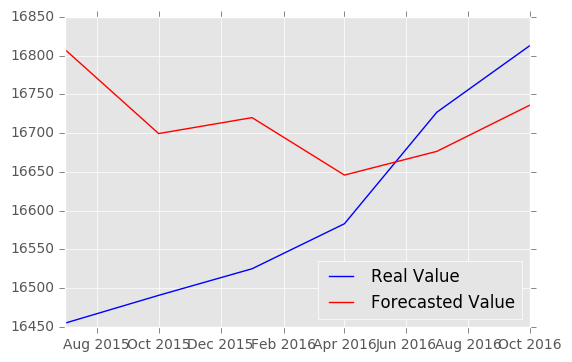

In [79]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])